# Query house matched preference

Assumpt the user has completed several turns of chat with chatbot, and we already get the preference of user.

embedding base chain output by chagpt embeddings and retrieval related houses from lancedb.

first we merge user preference into a list, then we embedding the merged list string and use it to query the lancedb and compare the house's descrption's similarity with user's preference, at last, we compose a prompt by using the user's preference and the retrievaled house list, and ask the chatGPT to rank the house based on users requirements. 

All this step is realized by using langchain.

In [13]:
#
import dotenv
import lancedb
from typing import List
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_community.vectorstores.lancedb import LanceDB
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import NumberedListOutputParser
dotenv.load_dotenv()

# prompt 
user_preference_template = """Ranking the result based on its suitability to users preference.
******\n
The users preference are list below:\n{user_require_list} \n
******\n
some related house information is: {context}\n
******\n
{format_instructions}
return result follow the format instructions and each item must be a json obect. 
In each json object, it must includes metadata of that house except vector.
In each json object, it must includes description of that house. 
add new key named 'suitability', the range is [0-1], 1 means all requirements satisfied.
******\n"""
parser = NumberedListOutputParser()

def build_vector_db_query(input: List[str]):
    require_list = ""
    for idx, user_require in enumerate(input["input"]):
        require_list += "{}. {}\n".format(idx+1, user_require)
    return require_list

from langchain_core.runnables import RunnableLambda
merge_pref = RunnableLambda(build_vector_db_query)
# retrieval
db = lancedb.connect('../tmp/lancedb')
table = db.open_table('house_match')

embedding_model = OpenAIEmbeddings()

vectorstore = LanceDB(table, embedding_model, text_key="description")
retrieval = vectorstore.as_retriever(
    search_kwargs = {'k':4}
)

# 1.1 merge input into one string
parse_chain = {"input": RunnablePassthrough()} | merge_pref
# 1.2 retrieval related house
rag = parse_chain | retrieval
# build prompt
prompt = ChatPromptTemplate.from_template(user_preference_template)
prompt = prompt.partial(format_instructions=parser.get_format_instructions())

prompt_build = {"context": rag, "user_require_list": parse_chain} | prompt

# generation 
from langchain_openai.chat_models import ChatOpenAI

chat_model = ChatOpenAI(temperature=0)

complete_chain = prompt_build | chat_model | parser

In [14]:
user_answer_example = [
    "I can only afford no more than 150,000 yen/month",
    "I want live near the sea.",
    "I want to live in some place only take 20 minutes to goto Ueno.",
    "I want to work into nearest subway station in 8 minutes.",
    "I hate noise but want to live in downtown area.",
]
output = complete_chain.invoke(user_answer_example)
output

['{"metadata": {"name": "Cozy Yokohama House", "year": "2015", "location": "Yokohama City, Naka Ward", "layout": "1LDK", "price": "¥150,000/month"}, "description": "This modern 1LDK house is perfect for couples or small families. It was built in 2015 and is located in Naka Ward, one of the most convenient and lively areas of Yokohama. The nearest subway station is a 5 minute walk away, and there is a supermarket just 10 minutes away on foot. The house is pet-friendly and has free wifi. Smoking is not allowed. There is an elevator in the building for easy access. Getting to Tokyo is a breeze with the nearby subway station. The neighborhood is also full of great restaurants, cafes, and shops. Don\'t miss out on this perfect rental opportunity in Yokohama!", "suitability": 0.8}',
 '{"metadata": {"name": "Yokohama Seaside Home", "year": "2005", "location": "Yokohama, Kanagawa Prefecture, Naka Ward", "layout": "2LDK", "price": "¥160,000/month"}, "description": "This beautiful 2LDK house is 

check the RAG result

In [15]:
rag_result = rag.invoke(user_answer_example)
rag_result

[Document(page_content='Fully furnished rental house located in the heart of Tokyo, just a 5 minute walk to the nearest subway station. Perfect for families or roommates who want to experience the city life. Pets and smoking are not allowed. Free wifi and elevator available. 10 minutes to the nearest supermarket by foot.', metadata={'name': 'Tokyo Terrace House', 'year': '1998', 'location': 'Tokyo, Shibuya ward', 'layout': '3LDK', 'price': '¥200,000/month', 'vector': array([ 0.00276634,  0.00476325, -0.03064654, ..., -0.01167829,
         0.00550007, -0.0261604 ], dtype=float32), '_distance': 0.28361162543296814}),
 Document(page_content="This modern 1LDK house is perfect for couples or small families. It was built in 2015 and is located in Naka Ward, one of the most convenient and lively areas of Yokohama. The nearest subway station is a 5 minute walk away, and there is a supermarket just 10 minutes away on foot. The house is pet-friendly and has free wifi. Smoking is not allowed. The

In the Rag provided suggestions, we get 4 related house resource, they are:

 - 1. "Tokyo Terrace House" (line 76)
 - 2. "Cozy Yokohama House" (line 103)
 - 3. "Fujisawa Cozy House"(line 16)
 - 4. "Yokohama Seaside Home" (line 207)

you can find it in the [generated_data](../data/chatgpt_house_match_data.csv)

In [16]:
# result visualize interface
import gradio as gr
import json

def parser_result(s):
    try:
        object = json.loads(s)
        return object
    except Exception as e:
        return {}

markdown_template = """
### House information\n
**{name}** \n
#### Basic Info\n
\n
Location: {location}\t\t\t\tLayout: {layout}\n
Price: {price}\t\t\t\tbuilt year: {year}\n
Description: {desc}\n
\n
"""
with gr.Blocks() as demo:
    for house in output:
        with gr.Column():
            house_meta = parser_result(house)
            gr.Markdown(
                markdown_template.format(
                    name = house_meta["metadata"]["name"],
                    location = house_meta["metadata"]["location"],
                    layout = house_meta["metadata"]["layout"], 
                    price = house_meta["metadata"]["price"], 
                    year = house_meta["metadata"]["year"],
                    desc = house_meta["description"], 
                )
            )
            gr.Label(
                {"suitability": house_meta["suitability"]}
            )

demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


result example

![alt text](image.png)

As the user want to live

    - "I can only afford no more than 150,000 yen/month",
    - "I want live near the sea.",
    - "I want to live in some place only take 20 minutes to goto Ueno.",
    - "I want to work into nearest subway station in 8 minutes.",
    - "I hate noise but want to live in downtown area.",

we merge the user preference first, and ask rag system to find some house align with this preference,
the LanceDB return the RAG result like

===1====

'name': 'Tokyo Terrace House', 
'year': '1998', 
'location': 'Tokyo, Shibuya ward', 
'layout': '3LDK',
'price': <span style="color:red">'¥200,000/month',</span>.

Fully furnished rental house located in the heart of Tokyo, just a 5 minute walk to the nearest subway station. Perfect for families or roommates who want to experience the city life. Pets and smoking are not allowed. Free wifi and elevator available. 10 minutes to the nearest supermarket by foot.

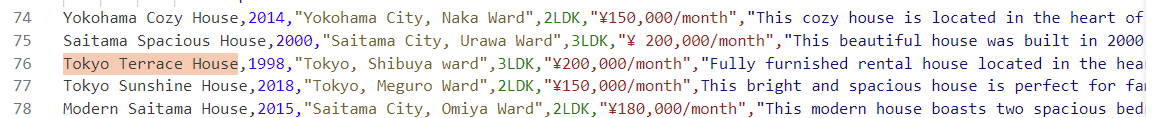

===2===

'name': 'Cozy Yokohama House'
'year': '2015'
'location': 'Yokohama City, Naka Ward'
'layout': '1LDK'
'price':  <span style="color:green">'¥150,000/month'</span>.

This modern 1LDK house is perfect for couples or small families. It was built in 2015 and is located in Naka Ward, one of the most convenient and lively areas of Yokohama. <span style="color:green">The nearest subway station is a 5 minute walk away</span>, and there is a supermarket just 10 minutes away on foot. The house is pet-friendly and has free wifi. Smoking is not allowed. There is an elevator in the building for easy access. Getting to Tokyo is a breeze with the nearby subway station. The neighborhood is also full of great restaurants, cafes, and shops. Don't miss out on this perfect rental opportunity in Yokohama!

======3=======

'name': 'Fujisawa Cozy House'
'year': '2015'
'location': 'Fujisawa, Kanagawa'
'layout': '2LDK'
'price': <span style="color:green">'¥150,000/month'</span>.

This cozy house is located in the quiet neighborhood of Fujisawa, a peaceful city in Kanagawa prefecture. It was built in 2015 and has a spacious 2LDK layout with 2 bedrooms, a living room, and a dining room. The rental price is ¥150,000 per month. Pets are allowed and smoking is only allowed on the balcony. Free wifi is provided. <span style="color:red">The nearest subway station is a 10-minute walk away and it takes 15 minutes to reach the station by bus.</span> The nearest supermarket is a 5-minute walk away. This house is perfect for a small family or couple looking for a quiet and comfortable home in Fujisawa.

=====4========

'name': 'Yokohama Seaside Home',
'year': '2005'
'location': 'Yokohama, Kanagawa Prefecture, Naka Ward'
'layout': '2LDK'
'price': <span style="color:red">'¥160,000/month'</span>
This beautiful 2LDK house is located in the seaside area of Yokohama, offering a peaceful and scenic living environment. Pets are allowed on the premises and there is free wifi provided. The building has an elevator, making it convenient for those with heavy luggage or mobility issues. It takes only 5 minutes to walk to the nearest subway station, Nihon-Odori, which connects to major train lines and makes it easy to travel around the city. There is also a 24-hour supermarket within a 10-minute walk from the house, making grocery shopping a breeze.


Then we compose a prompt by assert the rag returned context with user preference together, asking llm return the ranking ans a score of suitability. 
In the prompt, 
    1. First, I ask the llm first filter house which montly rental fee is higher than user's budget. which remove the 1 and 4.
    2. Second, I ask the llm to evaluate user preference one by one and score the suitability of that house. that 2 is satisfied the user requirements that want to go to nearest subway station in 10 minutes, but 3 does not(it takes about 10 minutes)
    3. At Last, I require the LLM to return the best 2 result with the suitability score.

By doing this, we find the best house match the users preference